In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import os
import seaborn as sns
import allen_v1dd.stimulus_analysis.analysis_tools as at
import scipy.stats as stats
import statsmodels.stats.multicomp as multi
from scipy.stats import bootstrap
from statsmodels.stats.multicomp import pairwise_tukeyhsd as multi_pairwise_tukeyhsd
from scipy.stats import ks_2samp
from pathlib import Path
from allen_v1dd.client.ophys_session import OPhysSession
from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import StimulusAnalysis, DriftingGratings
from v1dd_public import ARTIFACT_DIR
from matplotlib.colors import LinearSegmentedColormap

This example for tuning properties is the Allen V1DD repository: https://github.com/AllenInstitute/allen_v1dd/blob/main/chase/analysis_notebooks/2022-09-12_dg-compare.ipynb

In [3]:
DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
NWB_DATA_DIR = DATA_DIR / "nwbs"
client =  OPhysClient(DATA_DIR)
nwb_file_paths = list(NWB_DATA_DIR.glob("processed/*.nwb"))  
path = nwb_file_paths[0]

mouse_id = "M409828"
col_vol_id = "13"
plane = 1
session = client.load_ophys_session(f"{mouse_id}_{col_vol_id}")
dg = DriftingGratings(session, plane, trace_type = "dff", dg_type = "full")

In [4]:
dg_full = []
dg_windowed = []

for plane in session.get_planes()[:1]:
    dg_full.append(DriftingGratings(session, plane, dg_type="full"))
    dg_windowed.append(DriftingGratings(session, plane, dg_type="windowed"))
print(f"Analyzing {len(dg_full)} plane{'s' if len(dg_full) > 1 else ''}")

Analyzing 1 plane


In [5]:
reset_metrics = True

if reset_metrics:
    for dgf, dgw in zip(dg_full, dg_windowed):
        dgf._metrics = None
        dgw._metrics = None
        dgf.fit_tuning_curve = False
        dgw.fit_tuning_curve = False

dgf_metrics = StimulusAnalysis.concat_metrics(dg_full)
dgw_metrics = StimulusAnalysis.concat_metrics(dg_windowed)
ss_metrics = DriftingGratings.compute_surround_suppression_metrics(dg_full, dg_windowed)
n_tot = len(dgf_metrics)
dgf_metrics = dgf_metrics[dgf_metrics.is_valid]
dgw_metrics = dgw_metrics[dgw_metrics.is_valid]
ss_metrics = ss_metrics[ss_metrics.is_valid]

dgf_metrics["is_responsive"] = dgf_metrics.is_valid & dgf_metrics.frac_responsive_trials >= 0.5
dgw_metrics["is_responsive"] = dgw_metrics.is_valid & dgw_metrics.frac_responsive_trials >= 0.5

resp_full = dgf_metrics["is_responsive"]
resp_windowed = dgw_metrics["is_responsive"]
n_valid = len(dgf_metrics) # same no. ROIs for both dg_full and dg_windowed
n_both = np.logical_and(resp_full, resp_windowed).value_counts()[True]
n_full = resp_full.value_counts()[True]
n_windowed = resp_windowed.value_counts()[True]
n_full_only = n_full - n_both
n_windowed_only = n_windowed - n_both
n_either = np.logical_or(resp_full, resp_windowed).value_counts()[True]
n_neither = np.logical_and(~resp_full, ~resp_windowed).value_counts()[True]

print()
print(f"{n_valid}/{n_tot} ({n_valid/n_tot*100:.1f}%) ROIs are valid")
print(f"{n_full}/{n_valid} ({n_full/n_valid*100:.1f}%) ROIs are responsive to DG-full")
print(f"{n_windowed}/{n_valid} ({n_windowed/n_valid*100:.1f}%) ROIs are responsive to DG-windowed")
print()
print(f"{n_either}/{n_valid} ({n_either/n_valid*100:.1f}%) ROIs are responsive to DG-full OR DG-windowed")
print(f"{n_both}/{n_valid} ({n_both/n_valid*100:.1f}%) ROIs are responsive to BOTH DG-full AND DG-windowed")
print(f"{n_full_only}/{n_valid} ({n_full_only/n_valid*100:.1f}%) ROIs are responsive to ONLY DG-full")
print(f"{n_windowed_only}/{n_valid} ({n_windowed_only/n_valid*100:.1f}%) ROIs are responsive to ONLY DG-windowed")
print(f"{n_neither}/{n_valid} ({n_neither/n_valid*100:.1f}%) ROIs are responsive to NEITHER")

Loading DG-full response metrics for session M409828_13, plane 1...
Loading DG-windowed response metrics for session M409828_13, plane 1...

409/1234 (33.1%) ROIs are valid
352/409 (86.1%) ROIs are responsive to DG-full
374/409 (91.4%) ROIs are responsive to DG-windowed

397/409 (97.1%) ROIs are responsive to DG-full OR DG-windowed
329/409 (80.4%) ROIs are responsive to BOTH DG-full AND DG-windowed
23/409 (5.6%) ROIs are responsive to ONLY DG-full
45/409 (11.0%) ROIs are responsive to ONLY DG-windowed
12/409 (2.9%) ROIs are responsive to NEITHER


In [6]:
import allen_v1dd.stimulus_analysis.analysis_tools as at
def response_plot(index, plot="tuning", **kwargs):
    at.dg_response_plot(index, dgf_metrics, dg_full, dg_windowed, plot=plot, **kwargs)
    print(f"SSI of {index} = {ss_metrics.at[index, 'ssi']:.4f}")
    # plt.savefig("dg_tts.eps", format= "eps")

In [7]:
# response_plot("M409828_13_1_64", plot="condition_response", trace_type="events")
response_plot("M409828_13_1_64", plot="condition_response", trace_type="dff")
plt.savefig(os.path.join(ARTIFACT_DIR, "figures", "FIG3A_M409828_13_1_64_condition_response_dff.svg"))

KeyboardInterrupt: 

SSI of M409828_13_1_64 = 0.1115


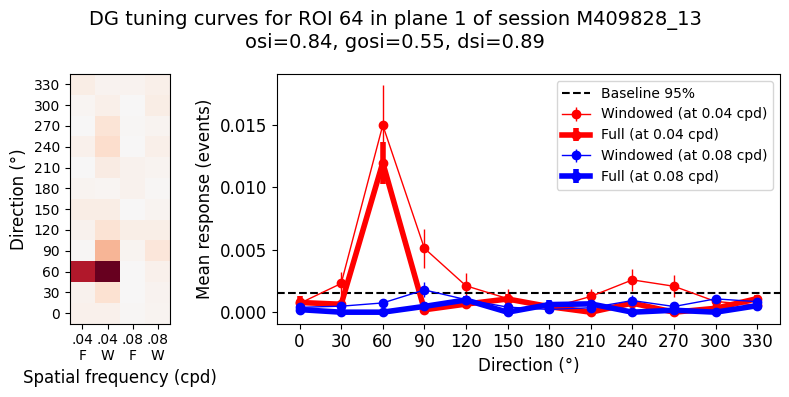

In [ ]:
def response_plot(index, plot="tuning", **kwargs):
    at.dg_response_plot(index, dgf_metrics, dg_full, dg_windowed, plot=plot, **kwargs)
    print(f"SSI of {index} = {ss_metrics.at[index, 'ssi']:.4f}")
    # plt.savefig("dg_tuning.eps", format= "eps")
    
response_plot("M409828_13_1_64", plot="tuning")
plt.savefig(os.path.join(ARTIFACT_DIR, "figures", "FIG3B_PANEL1AND3_M409828_13_1_64_dg_tuning.svg"))

[  0  30  60  90 120 150 180 210 240 270 300 330]
[-180 -150 -120  -90  -60  -30    0   30   60   90  120  150  180]
[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]


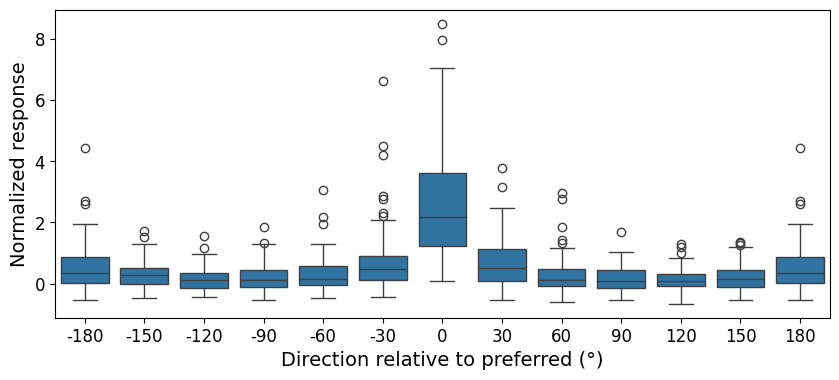

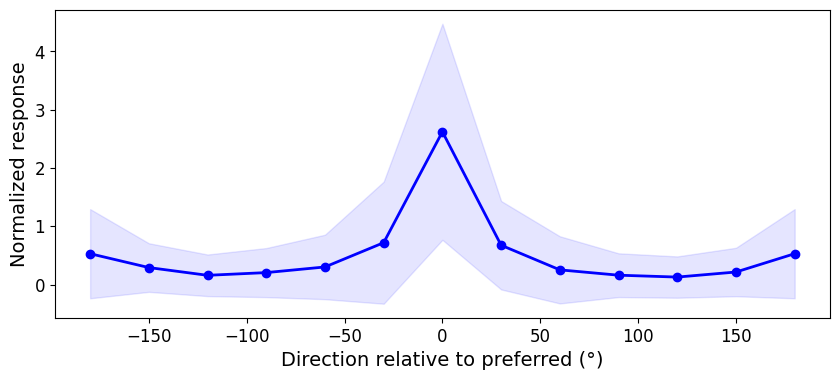

In [ ]:
dg = dgw
dir_list = dg.dir_list
relative_dir_list = np.array([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
relative_dir_idx = np.arange(13) - 6

print(dir_list)
print(relative_dir_list)
print(relative_dir_idx)

x = []
y = []
y_ffsi = []

def ratio(a, b):
    if b == 0:
        return 0
    return a/b

for roi in range(dg.n_rois):
    if dg.is_roi_valid[roi] and dg.metrics.frac_responsive_trials[roi] >= 0.5:
        pref_dir_idx = dg.metrics.at[roi, "pref_dir_idx"]
        pref_sf_idx = dg.metrics.at[roi, "pref_sf_idx"]
        null_mean = dg._null_dist_multi_trial[roi].mean()
        null_std = dg._null_dist_multi_trial[roi].std()
        mean_grating_response = np.nanmean(dg.trial_responses[roi])
        mean_blank_response = dg.blank_responses[roi].mean()

        for dir_offset, reldir in zip(relative_dir_idx, relative_dir_list):
            dir_i = (pref_dir_idx+dir_offset) % len(dir_list)
            resp = dg.get_mean_response(roi, dir_i, pref_sf_idx)
            norm_resp = (resp - mean_blank_response) / (mean_grating_response + mean_blank_response)

            resp_f = dgf.get_mean_response(roi, dir_i, pref_sf_idx)
            ffsi = ratio(max(resp, resp_f) - resp_f, max(resp, resp_f))

            x.append(reldir)
            y.append(norm_resp)
            y_ffsi.append(ffsi)

# Box plot
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
sns.boxplot(x=x, y=y, ax=ax)
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("Normalized response", fontsize=14)

# Line plot of means ± error
y_by_dir_idx = [[yy for xx, yy in zip(x, y) if xx == reldir] for reldir in relative_dir_list]
y_means = np.array([np.mean(arr) for arr in y_by_dir_idx])
y_err = np.array([np.std(arr) for arr in y_by_dir_idx])
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("Normalized response", fontsize=14)
ax.plot(relative_dir_list, y_means, color="blue", linewidth=2, marker=".", markersize=12)
ax.fill_between(relative_dir_list, y_means-y_err, y_means+y_err, color="blue", alpha=0.1)

plt.savefig(os.path.join(ARTIFACT_DIR, "figures", "FIG3B_PANEL2_M409828_13_1_64_dg_tuning.svg"))

### Load in cell_info dataframe to look at population trends

In [10]:
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

### Next couple plots are the KDE plots of correlation between DGF/DGW metrics

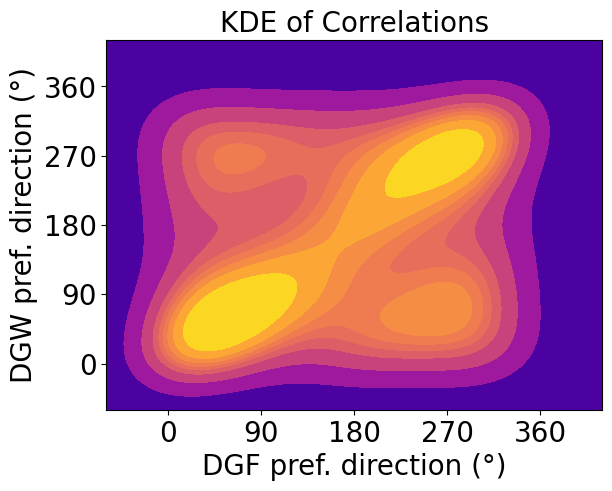

In [11]:
titles = ['dgf_pref_dir', 'dgw_pref_dir', 'dgf_osi', 'dgw_osi', 'dgf_dsi', 'dgw_dsi', 'dgf_ls', 'dgw_ls']
ax = sns.kdeplot(x=cell_info['dgf_pref_dir'], y=cell_info['dgw_pref_dir'], cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=10, cut=10)
font=20
plt.xticks(range(0, 361, 90), fontsize=font)
plt.yticks(range(0, 361, 90), fontsize=font)
plt.title("KDE of Correlations", fontsize=font)
plt.xlabel('DGF pref. direction (°)', fontsize=font)
plt.ylabel('DGW pref. direction (°)', fontsize=font)
plt.xlim(-60, 420)
plt.ylim(-60, 420)

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG3C_panel1_kde_prefdir.svg'), format='svg', dpi=300)

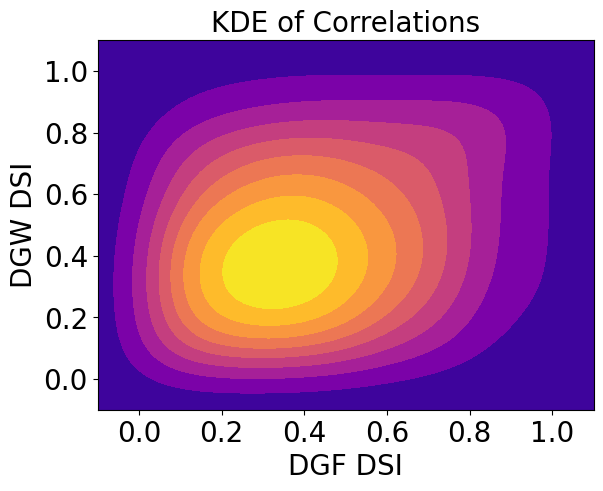

In [12]:
sns.kdeplot(x=cell_info['dgf_dsi'], y=cell_info['dgw_dsi'], cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=10, cut=10)
font = 20
plt.xticks(np.arange(0, 1.2, 0.2), fontsize=font)
plt.yticks(np.arange(0, 1.2, 0.2), fontsize=font)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.title("KDE of Correlations", fontsize=font)
plt.xlabel('DGF DSI', fontsize=font)
plt.ylabel('DGW DSI', fontsize=font)

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG3C_panel2_kde_dsi.svg'), format='svg', dpi=300)

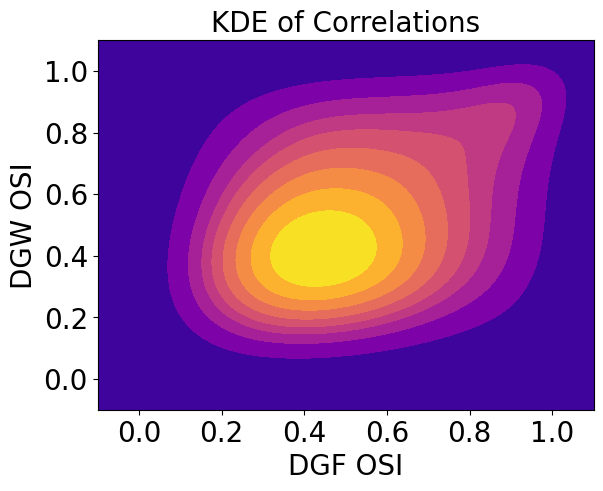

In [13]:
ax = sns.kdeplot(x=cell_info['dgf_osi'], y=cell_info['dgw_osi'], cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=10, cut=10)
font = 20
plt.xticks(np.arange(0, 1.2, 0.2), fontsize=font)
plt.yticks(np.arange(0, 1.2, 0.2), fontsize=font)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.title("KDE of Correlations", fontsize=font)
plt.xlabel('DGF OSI', fontsize=font)
plt.ylabel('DGW OSI', fontsize=font)

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG3C_panel3_kde_osi.svg'), format='svg', dpi=300)

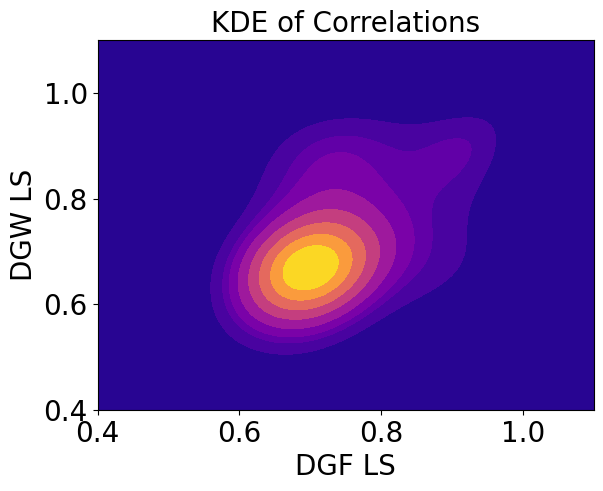

In [14]:
ax = sns.kdeplot(x=cell_info['dgf_ls'], y=cell_info['dgw_ls'], cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=10, cut=10)
font = 20
plt.xticks(np.arange(0.4, 1.2, 0.2), fontsize=font)
plt.yticks(np.arange(0.4, 1.2, 0.2), fontsize=font)
plt.xlim(0.4, 1.1)
plt.ylim(0.4, 1.1)
plt.title("KDE of Correlations", fontsize=font)
plt.xlabel('DGF LS', fontsize=font)
plt.ylabel('DGW LS', fontsize=font) 

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG3C_panel4_kde_ls.svg'), format='svg', dpi=300)

### Depth-dependent trends (one for main figure and one is for supplementary figure)

In [15]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]

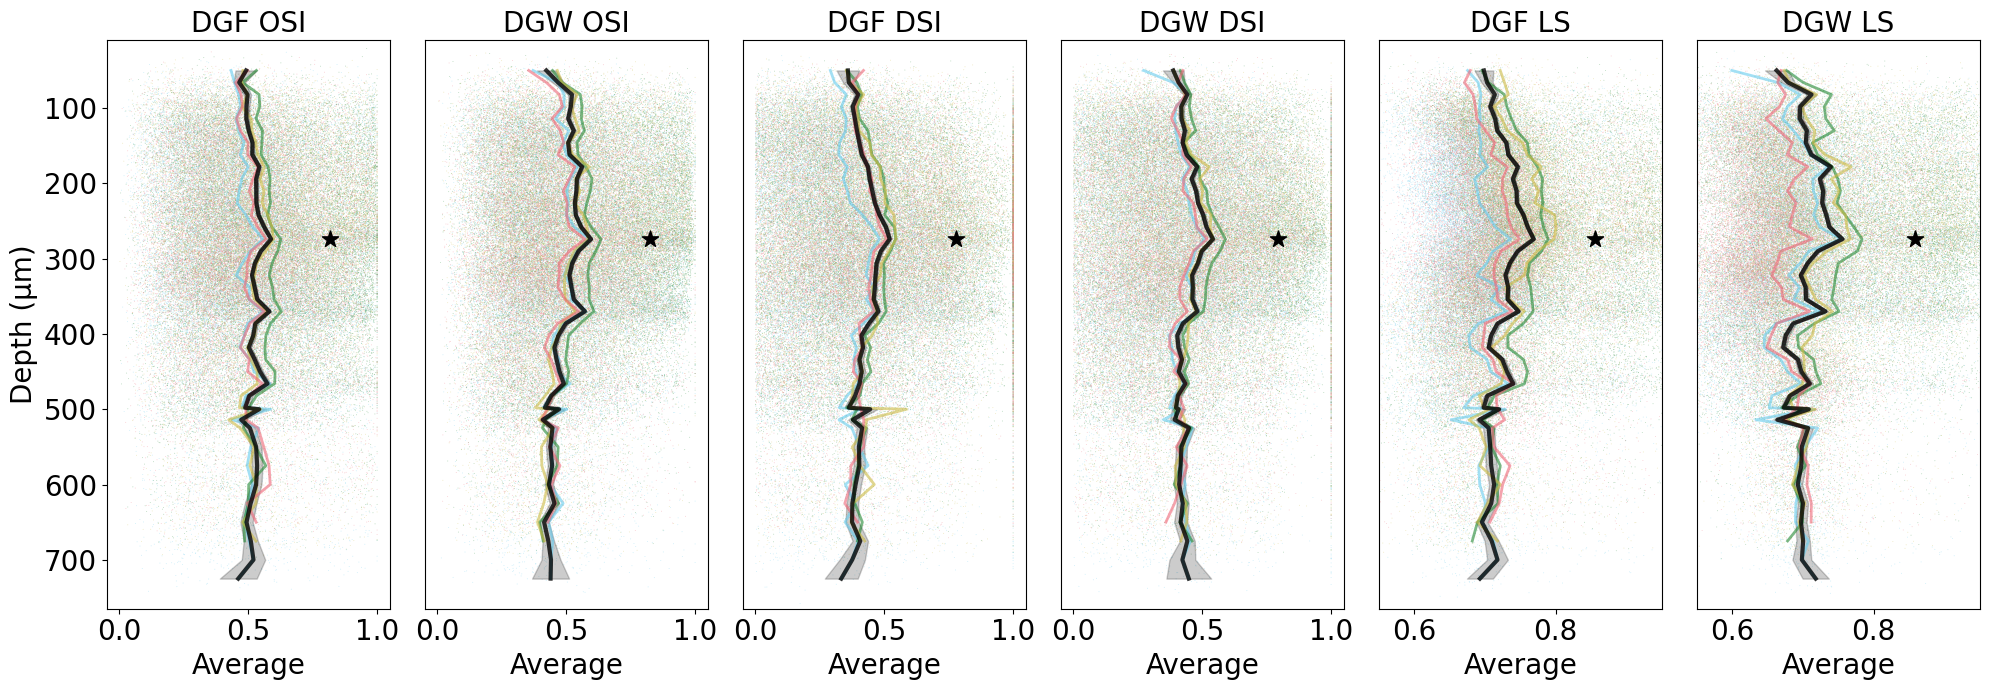

In [16]:
fontsize = 20
jitter_amount = 10
z_values = cell_info['z'].values

stim_list = ['dgf_osi', 'dgw_osi', 'dgf_dsi', 'dgw_dsi', 'dgf_ls', 'dgw_ls']
titles = ['DGF OSI', 'DGW OSI', 'DGF DSI', 'DGW DSI', 'DGF LS', 'DGW LS']
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}

fig, axs = plt.subplots(1, len(stim_list), figsize=(20, 7))
for idx, stim in enumerate(stim_list):
    sns.lineplot(data=cell_info, 
                 x=stim, 
                 y='z',  
                 hue='mouse_id', 
                 estimator='mean',
                 palette=mouse_colors, 
                 linewidth=2, 
                 errorbar=None, 
                 alpha=0.6, 
                 orient='y', 
                 markers=True,
                 ax=axs[idx],
                 legend=False # if idx != 5 else True,
                 )
    # axs[idx].legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], 
    #     loc='upper right', bbox_to_anchor=(2, 1), fontsize=fontsize, title_fontsize=fontsize) if idx == 5 else None

    sns.lineplot(data=cell_info, 
                 x=stim, 
                 y='z', 
                 color='black', 
                 estimator='mean',
                 err_style='band', 
                 errorbar=('se', 2), 
                 n_boot=1000, 
                 linewidth=3, 
                 alpha=0.8, 
                 orient='y', 
                 ax=axs[idx], 
                 legend=False)

    temp_df = cell_info.copy()
    temp_df['z'] = temp_df['z'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    if stim == 'dgf_pref_dir' or stim == 'dgw_pref_dir':
        temp_df[stim] = temp_df[stim] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
                    x=stim,
                    y='z',
                    hue='mouse_id',
                    palette=mouse_colors,
                    s=0.4,
                    alpha=0.4,
                    ax=axs[idx],
                    legend=False,
                    zorder=0,
    )

    # Put asterisk next to the depth where the max median
    sub_df = cell_info.groupby('z')[stim].mean().reset_index()
    sub_array = sub_df[stim].values
    axs[idx].scatter(sub_array.max() + cell_info[stim].std(), sub_df.iloc[np.where(sub_array == sub_array.max())].z.values[0], 
            color='black', marker='*', s=150, edgecolor='black', zorder=1)

    axs[idx].set_xlabel('Average', fontsize=fontsize)
    axs[idx].set_title(titles[idx], fontsize=fontsize)
    axs[idx].set_ylabel("Depth (µm)", fontsize=fontsize) if idx == 0 else axs[idx].set_ylabel(" ")
    axs[idx].set_yticks([]) if idx != 0 else None
    axs[idx].set_ylim(z_values.min() - 40, z_values.max() + 40)
    axs[idx].set_xlim(-0.05, 1.05) if idx < 4 else axs[idx].set_xlim(0.55, 0.95)
    axs[idx].tick_params(axis="both", which="major", labelsize=fontsize)
    axs[idx].invert_yaxis()

plt.tight_layout()
fig.savefig(os.path.join(ARTIFACT_DIR, "figures", "FIG3D_dg_depth_plots.png"), format='png', dpi=300)

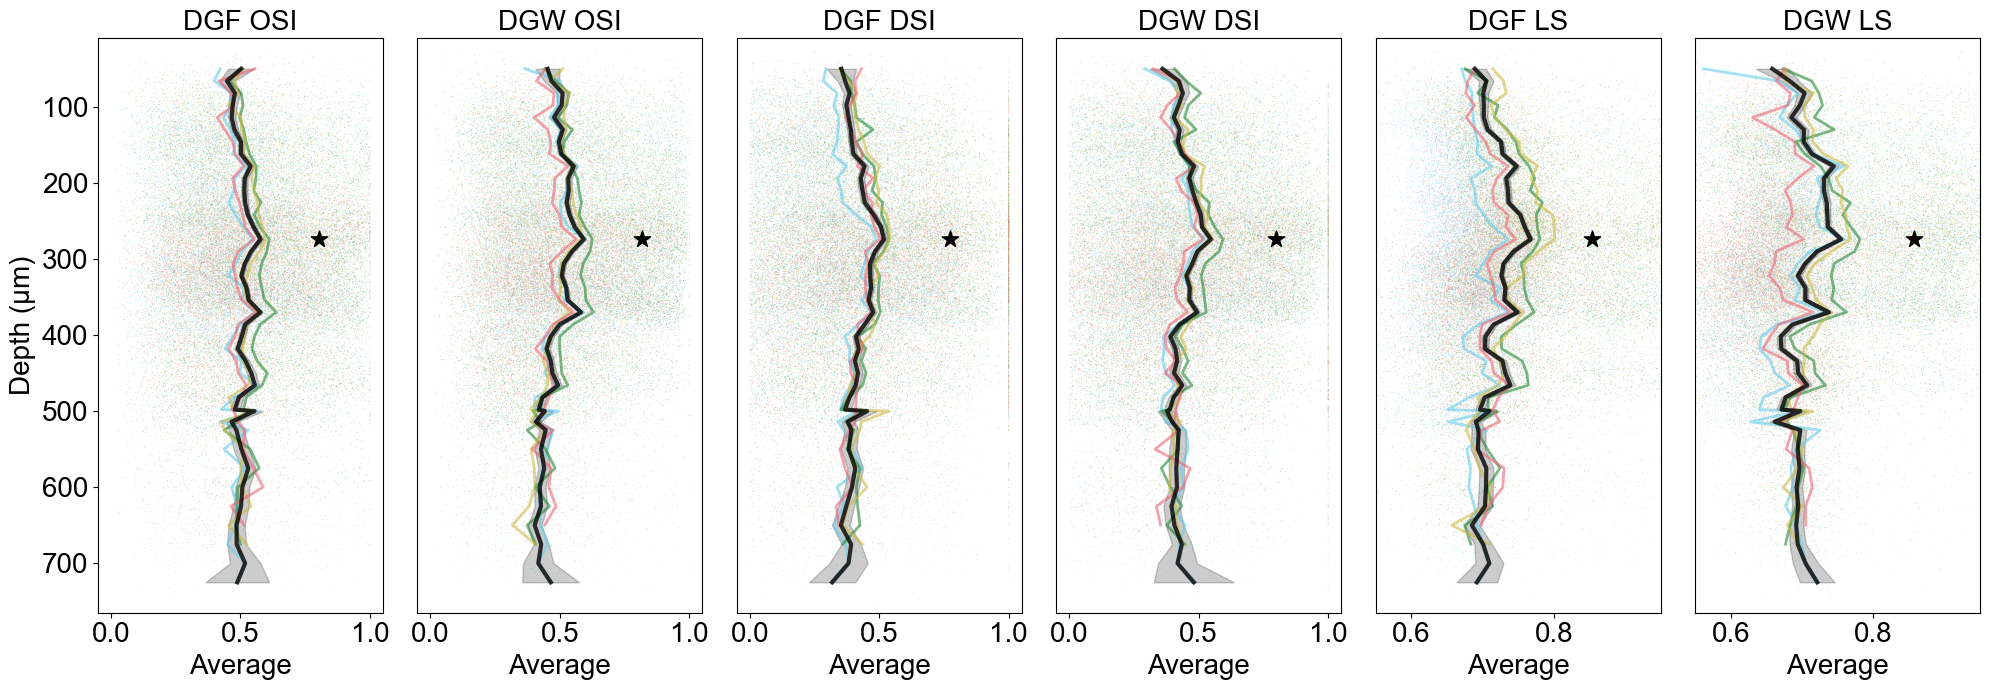

In [36]:
fontsize = 20
jitter_amount = 10
z_values = cell_info['z'].values
cell_info_resp = cell_info[cell_info['is_responsive'] == True]

stim_list = ['dgf_osi', 'dgw_osi', 'dgf_dsi', 'dgw_dsi', 'dgf_ls', 'dgw_ls']
titles = ['DGF OSI', 'DGW OSI', 'DGF DSI', 'DGW DSI', 'DGF LS', 'DGW LS']
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}

fig, axs = plt.subplots(1, len(stim_list), figsize=(20, 7))
for idx, stim in enumerate(stim_list):
    sns.lineplot(data=cell_info_resp, 
                 x=stim, 
                 y='z',  
                 hue='mouse_id', 
                 estimator='mean',
                 palette=mouse_colors, 
                 linewidth=2, 
                 errorbar=None, 
                 alpha=0.6, 
                 orient='y', 
                 markers=True,
                 ax=axs[idx],
                 legend=False # if idx != 5 else True,
                 )
    # axs[idx].legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], 
    #     loc='upper right', bbox_to_anchor=(2, 1), fontsize=fontsize, title_fontsize=fontsize) if idx == 5 else None

    sns.lineplot(data=cell_info_resp, 
                 x=stim, 
                 y='z', 
                 color='black', 
                 estimator='mean',
                 err_style='band', 
                 errorbar=('se', 2), 
                 n_boot=1000, 
                 linewidth=3, 
                 alpha=0.8, 
                 orient='y', 
                 ax=axs[idx], 
                 legend=False)

    temp_df = cell_info_resp.copy()
    temp_df['z'] = temp_df['z'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    if stim == 'dgf_pref_dir' or stim == 'dgw_pref_dir':
        temp_df[stim] = temp_df[stim] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
                    x=stim,
                    y='z',
                    hue='mouse_id',
                    palette=mouse_colors,
                    s=0.4,
                    alpha=0.4,
                    ax=axs[idx],
                    legend=False,
                    zorder=0,
    )

    # Put asterisk next to the depth where the max median
    sub_df = cell_info_resp.groupby('z')[stim].mean().reset_index()
    sub_array = sub_df[stim].values
    axs[idx].scatter(sub_array.max() + cell_info_resp[stim].std(), sub_df.iloc[np.where(sub_array == sub_array.max())].z.values[0], 
            color='black', marker='*', s=150, edgecolor='black', zorder=1)

    axs[idx].set_xlabel('Average', fontsize=fontsize)
    axs[idx].set_title(titles[idx], fontsize=fontsize)
    axs[idx].set_ylabel("Depth (µm)", fontsize=fontsize) if idx == 0 else axs[idx].set_ylabel(" ")
    axs[idx].set_yticks([]) if idx != 0 else None
    axs[idx].set_ylim(z_values.min() - 40, z_values.max() + 40)
    axs[idx].set_xlim(-0.05, 1.05) if idx < 4 else axs[idx].set_xlim(0.55, 0.95)
    axs[idx].tick_params(axis="both", which="major", labelsize=fontsize)
    axs[idx].invert_yaxis()

plt.tight_layout()
fig.savefig(os.path.join(ARTIFACT_DIR, "figures", "SUPPFIG3_dg_depth_plots_resp.png"), format='png', dpi=300)

### Running the stats tests for depth-dependent trends

In [18]:
cell_info

Unnamed: 0.1 mouse_id  Unnamed: 0  valid_cell_index  cell_index  \
0              8542     slc2        8542                 0           0   
1              8543     slc2        8543                 1           1   
2              8544     slc2        8544                 2           2   
3              8545     slc2        8545                 3           3   
4              8546     slc2        8546                 4           4   
...             ...      ...         ...               ...         ...   
88346         31308    teto1       31308                 1          10   
88347         31309    teto1       31309                 2          14   
88348         31310    teto1       31310                 3          22   
88349         31311    teto1       31311                 4          23   
88350         31312    teto1       31312                 5          39   

      col_vol column volume  plane    x  ...  dgw_pref_dir   dgf_osi  \
0          16      1      6      0  236  ...           150  0.214924   
1          16      1      6      0  159  ...            90  0.765341   
2          16      1      6      0  193  ...           240  0.447789   
3          16      1      6      0  230  ...             0  0.661951   
4          16      1      6      0   61  ...           330  0.503441   
...       ...    ...    ...    ...  ...  ...           ...       ...   
88346      55      5      5      5   75  ...           330  0.468661   
88347      55      5      5      5  146  ...            30  0.472712   
88348      55      5      5      5   64  ...            30  0.621726   
88349      55      5      5      5   81  ...            30  0.645523   
88350      55      5      5      5  185  ...           300  0.396786   

        dgw_osi   dgf_dsi   dgw_dsi    dgf_ls    dgw_ls   ns12_ls  ns118_ls  \
0      0.485850  0.143261  0.394904  0.650162  0.670042  0.941426  0.943378   
1      0.699801  0.934434  0.180604  0.914330  0.874348  0.962018  0.940841   
2      0.317350  0.389030  0.267353  0.655039  0.657950  0.954018  0.956597   
3      0.464806  0.056502  0.402281  0.667079  0.674886  0.944030  0.944862   
4      0.748724  0.523120  1.000000  0.684561  0.845968  0.962426  0.954630   
...         ...       ...       ...       ...       ...       ...       ...   
88346  0.442844  0.431271  0.186935  0.704613  0.650555  0.958025  0.958414   
88347  0.459277  0.115886  0.715226  0.744843  0.692046  0.960391  0.955787   
88348  0.329101  0.511249  0.381324  0.752169  0.670320  0.948195  0.958985   
88349  0.602708  0.314335  0.497443  0.712573  0.708187  0.969706  0.949666   
88350  0.237160  0.287239  0.551275  0.681669  0.666547  0.950207  0.943412   

          nm_ls  
0      0.930728  
1      0.954807  
2      0.921463  
3      0.933212  
4      0.959651  
...         ...  
88346  0.939933  
88347  0.922388  
88348  0.928885  
88349  0.934391  
88350  0.927449  

[88351 rows x 82 columns]

In [24]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

In [ ]:
# -----------------------------
# Helper to convert p → stars
# -----------------------------
def p_to_stars(p):
    alpha_levels = [0.05, 0.01, 0.001, 0.0001]  # thresholds for *, **, ***, ****
    if np.isnan(p):
        return ""
    if p < alpha_levels[3]:
        return "****"
    elif p < alpha_levels[2]:
        return "***"
    elif p < alpha_levels[1]:
        return "**"
    elif p < alpha_levels[0]:
        return "*"
    return ""

In [31]:
cell_info

Unnamed: 0.1 mouse_id  Unnamed: 0  valid_cell_index  cell_index  \
0              8542     slc2        8542                 0           0   
1              8543     slc2        8543                 1           1   
2              8544     slc2        8544                 2           2   
3              8545     slc2        8545                 3           3   
4              8546     slc2        8546                 4           4   
...             ...      ...         ...               ...         ...   
88346         31308    teto1       31308                 1          10   
88347         31309    teto1       31309                 2          14   
88348         31310    teto1       31310                 3          22   
88349         31311    teto1       31311                 4          23   
88350         31312    teto1       31312                 5          39   

      col_vol column volume  plane    x  ...  dgw_pref_dir   dgf_osi  \
0          16      1      6      0  236  ...           150  0.214924   
1          16      1      6      0  159  ...            90  0.765341   
2          16      1      6      0  193  ...           240  0.447789   
3          16      1      6      0  230  ...             0  0.661951   
4          16      1      6      0   61  ...           330  0.503441   
...       ...    ...    ...    ...  ...  ...           ...       ...   
88346      55      5      5      5   75  ...           330  0.468661   
88347      55      5      5      5  146  ...            30  0.472712   
88348      55      5      5      5   64  ...            30  0.621726   
88349      55      5      5      5   81  ...            30  0.645523   
88350      55      5      5      5  185  ...           300  0.396786   

        dgw_osi   dgf_dsi   dgw_dsi    dgf_ls    dgw_ls   ns12_ls  ns118_ls  \
0      0.485850  0.143261  0.394904  0.650162  0.670042  0.941426  0.943378   
1      0.699801  0.934434  0.180604  0.914330  0.874348  0.962018  0.940841   
2      0.317350  0.389030  0.267353  0.655039  0.657950  0.954018  0.956597   
3      0.464806  0.056502  0.402281  0.667079  0.674886  0.944030  0.944862   
4      0.748724  0.523120  1.000000  0.684561  0.845968  0.962426  0.954630   
...         ...       ...       ...       ...       ...       ...       ...   
88346  0.442844  0.431271  0.186935  0.704613  0.650555  0.958025  0.958414   
88347  0.459277  0.115886  0.715226  0.744843  0.692046  0.960391  0.955787   
88348  0.329101  0.511249  0.381324  0.752169  0.670320  0.948195  0.958985   
88349  0.602708  0.314335  0.497443  0.712573  0.708187  0.969706  0.949666   
88350  0.237160  0.287239  0.551275  0.681669  0.666547  0.950207  0.943412   

          nm_ls  
0      0.930728  
1      0.954807  
2      0.921463  
3      0.933212  
4      0.959651  
...         ...  
88346  0.939933  
88347  0.922388  
88348  0.928885  
88349  0.934391  
88350  0.927449  

[88351 rows x 82 columns]

In [35]:
import matplotlib
matplotlib.rc('font', family='Arial')

/home/naomi/anaconda3/envs/v1dd-public-1/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Best depth = 274, mean accuracy = 0.578


/home/naomi/anaconda3/envs/v1dd-public-1/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Best depth = 274, mean accuracy = 0.593


/home/naomi/anaconda3/envs/v1dd-public-1/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Best depth = 274, mean accuracy = 0.518


/home/naomi/anaconda3/envs/v1dd-public-1/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-1/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Best depth = 274, mean accuracy = 0.547


/home/naomi/anaconda3/envs/v1dd-public-1/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Best depth = 274, mean accuracy = 0.768


/home/naomi/anaconda3/envs/v1dd-public-1/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Best depth = 274, mean accuracy = 0.755


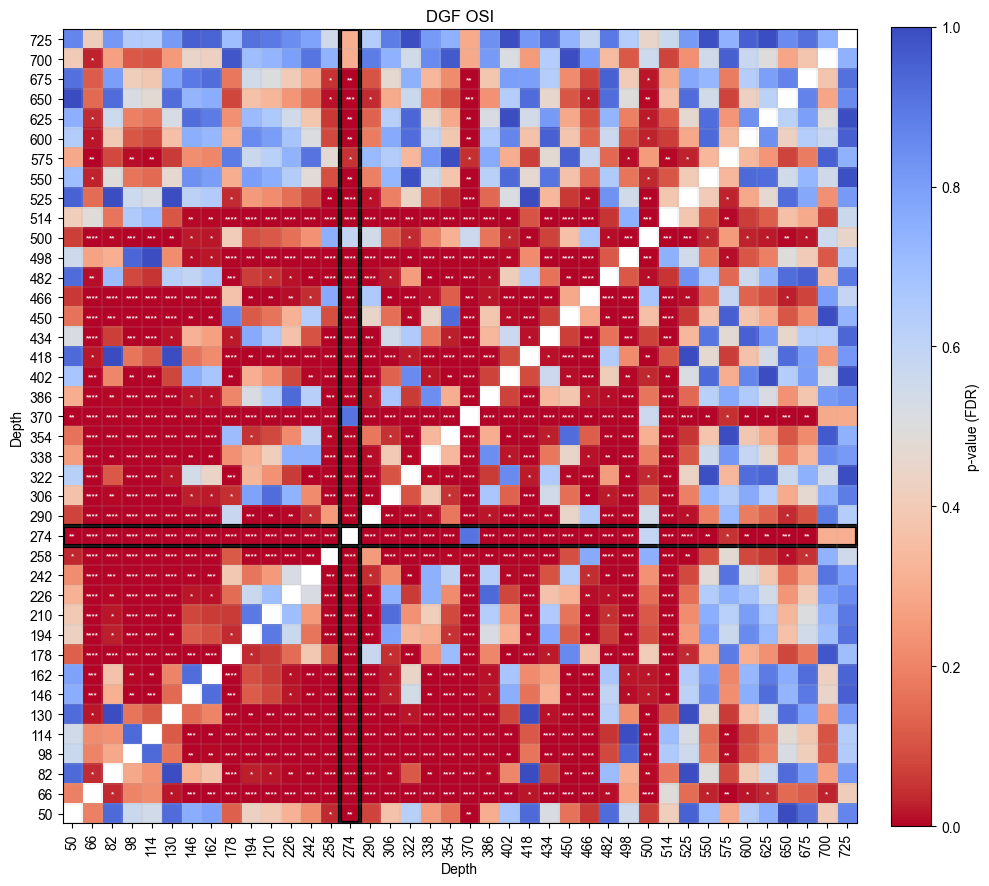

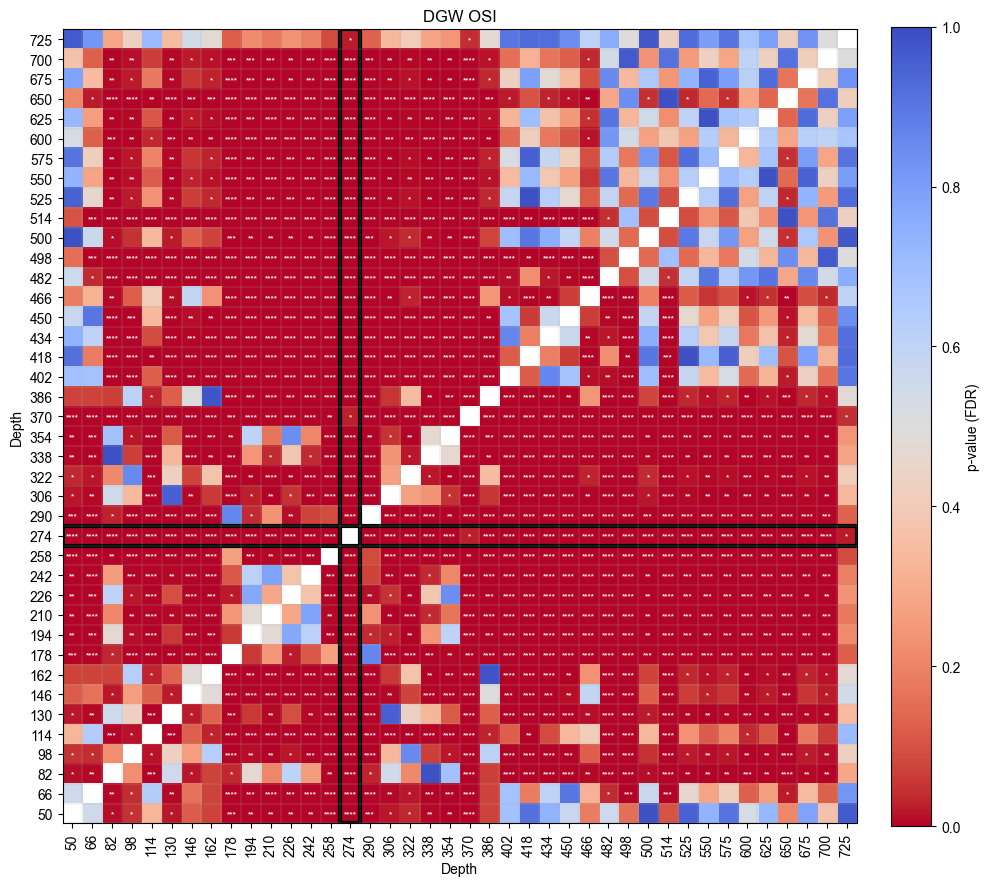

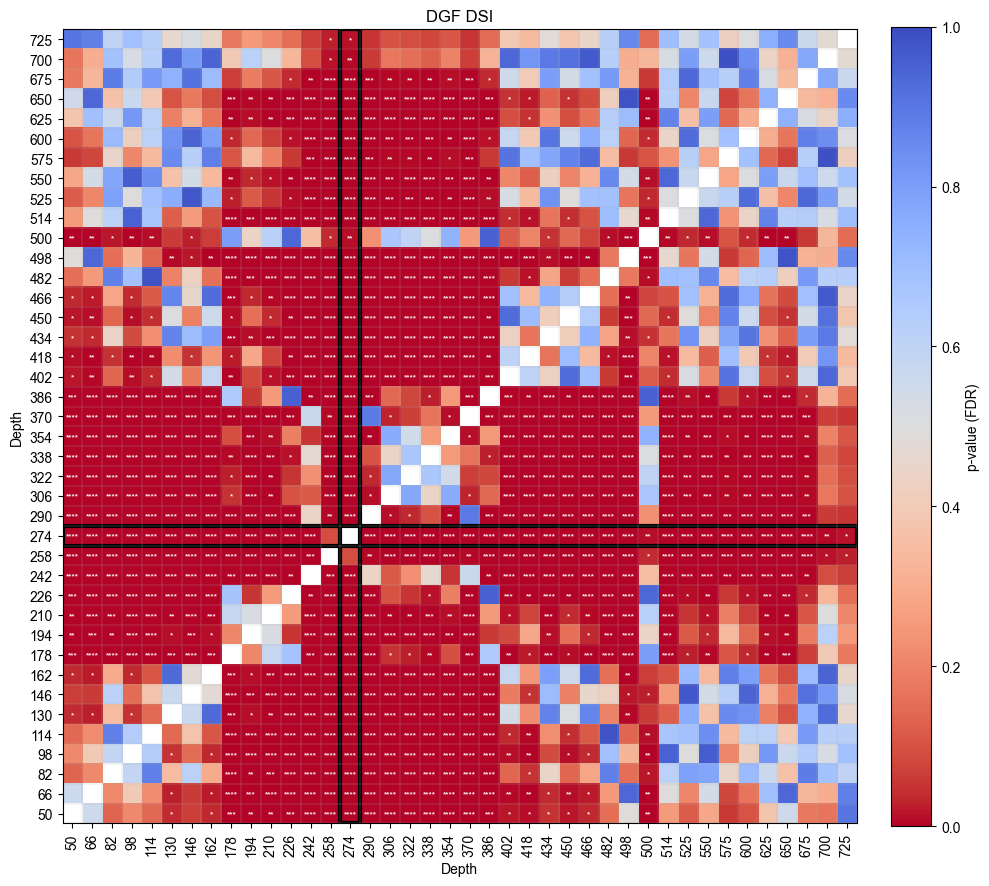

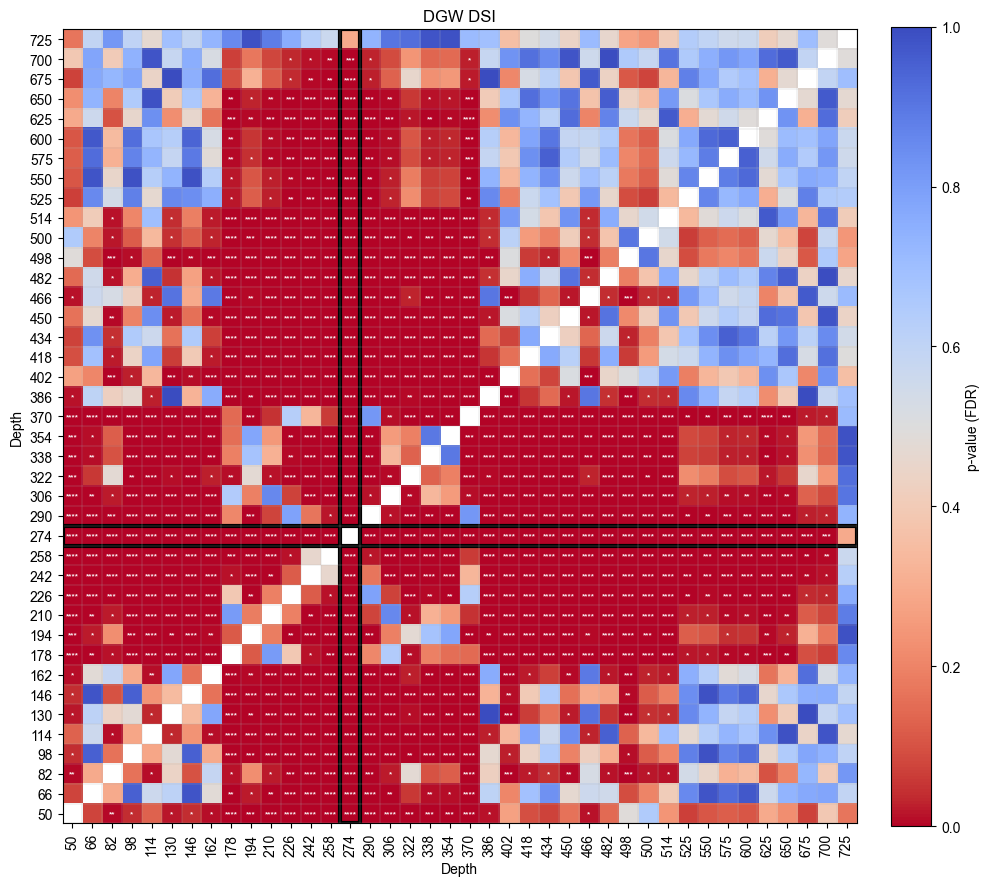

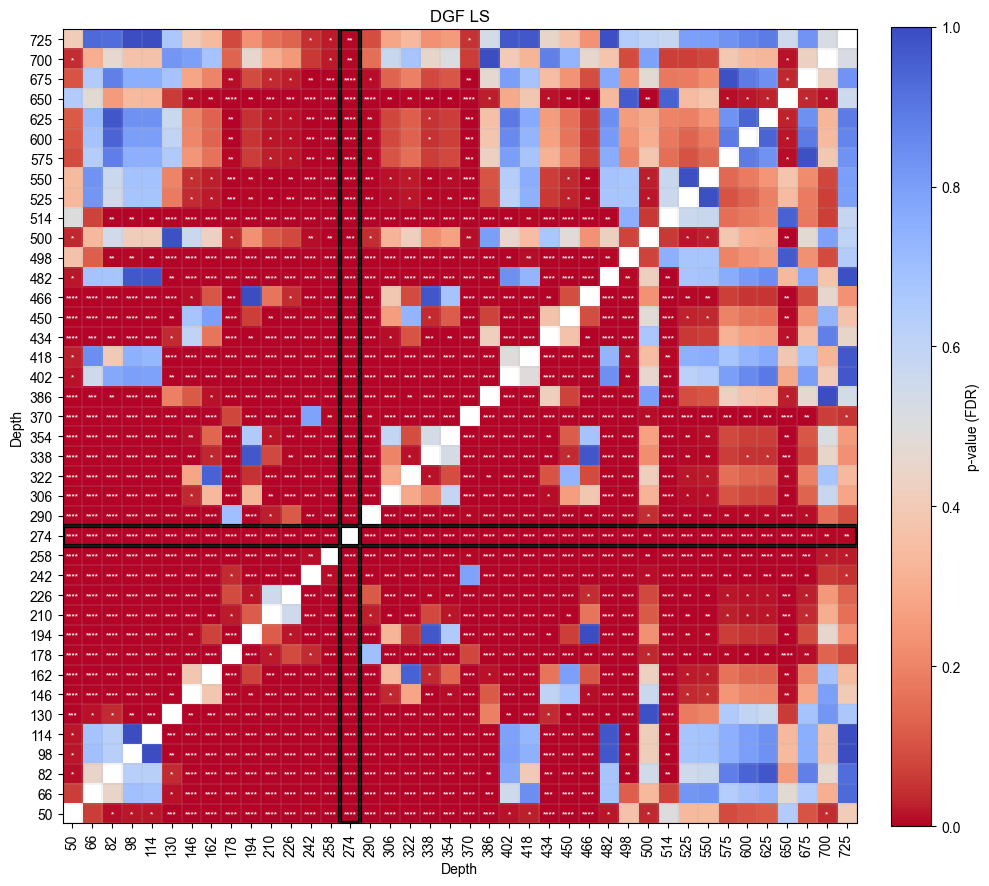

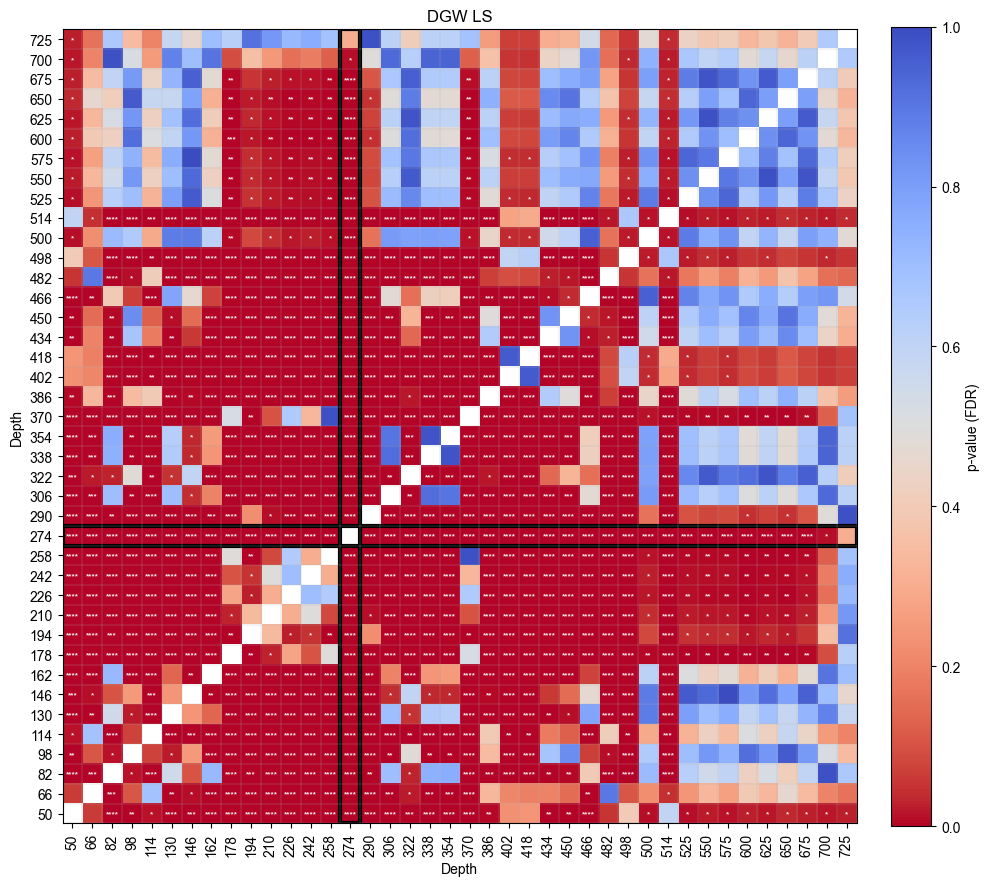

In [38]:
stim_list = ['dgf_osi', 'dgw_osi', 'dgf_dsi', 'dgw_dsi', 'dgf_ls', 'dgw_ls']
titles = ['DGF OSI', 'DGW OSI', 'DGF DSI', 'DGW DSI', 'DGF LS', 'DGW LS']
is_resp = True

for idx, stim_type in enumerate(stim_list):
    if is_resp: 
        df = cell_info[cell_info['is_responsive'] == True][['mouse_id', 'column', 'z', stim_type]]
    else:
        df = cell_info[['mouse_id', 'column', 'z', stim_type]]
    df = df.sort_values(by='z').reset_index(drop=True)
    df['mouse_id'] = df['mouse_id'].astype('category')
    df['column'] = df['column'].astype('category')
    df['z'] = df['z'].astype('category')
    depth_levels = df.z.unique()

    # 2) Fit the mixed model: accuracy ~ depth + (1|mouse) + (1|mouse:column)
    res = smf.mixedlm(
        f"{stim_type} ~ C(z)",
        data=df,
        groups=df["mouse_id"],
        re_formula="~1",
        vc_formula={"column": "0 + C(column)"}
    ).fit(method="lbfgs")

    # 3) Build “EMM” vectors (fixed-effects means per depth)
    fe_names = res.fe_params.index.tolist()
    beta = res.fe_params.values
    Sigma = res.cov_params().loc[fe_names, fe_names].values  # cov of fixed effects
    baseline = depth_levels[0]

    def v_for(level):
        v = np.zeros(len(fe_names))
        v[fe_names.index("Intercept")] = 1.0
        name = f"C(z)[T.{level}]"
        if name in fe_names: v[fe_names.index(name)] = 1.0
        return v

    R = np.vstack([v_for(d) for d in depth_levels])  # rows are depths

    # 4) Pairwise contrasts for all depth pairs
    rows = []
    for i, j in itertools.combinations(range(len(depth_levels)), 2):
        L = R[i] - R[j]
        diff = float(L @ beta)
        se   = float(np.sqrt(L @ Sigma @ L))
        z    = diff / se if se > 0 else np.inf
        p    = 2 * (1 - norm.cdf(abs(z)))
        rows.append({
            "depth_a": depth_levels[i],
            "depth_b": depth_levels[j],
            "diff": diff,
            "se": se,
            "z": z,
            "p_raw": p
        })
    contrasts = pd.DataFrame(rows)

    # 5) Add FDR (BH)
    contrasts["p_fdr_bh"]    = multipletests(contrasts["p_raw"], method="fdr_bh")[1]

    # Done: 'contrasts' now has raw and FDR p-values for every pair
    contrasts.sort_values("p_fdr_bh", inplace=True)

    ########### Plotting ###########
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    show_upper_triangle_only = False             # set False to show entire matrix
    mark_diagonal = False                       # usually we leave diagonal unmarked

    ## Build the matrix of p-values
    depth_to_idx = {d:i for i,d in enumerate(depth_levels)}
    K = len(depth_levels)

    P = np.ones((K, K), dtype=float)  # initialize to 1s (diagonal = 1)
    for _, row in contrasts.iterrows():
        i = depth_to_idx[row["depth_a"]]
        j = depth_to_idx[row["depth_b"]]
        p = float(row["p_fdr_bh"])
        P[i, j] = p
        P[j, i] = p

    if not mark_diagonal:
        np.fill_diagonal(P, np.nan)  # keep diagonal neutral/blank

    # Optionally only plot upper triangle
    if show_upper_triangle_only:
        mask = np.tril(np.ones_like(P, dtype=bool), k=0)  # lower triangle + diag masked
        P_plot = P.copy()
        P_plot[mask] = np.nan
    else:
        P_plot = P

    im = ax.imshow(P_plot, origin="lower", interpolation="nearest", vmin=0, vmax=1, cmap="coolwarm_r", rasterized=True)

    # Colorbar labeled with plain p-values
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("p-value (FDR)")

    # Ticks & labels
    ax.set_xticks(np.arange(K))
    ax.set_yticks(np.arange(K))
    ax.set_xticklabels(depth_levels, rotation=90)
    ax.set_yticklabels(depth_levels)
    ax.set_xlabel("Depth")
    ax.set_ylabel("Depth")
    ax.set_title(f"{titles[idx]}") # - Pairwise Depth Comparisons (Mixed LME)\nHeat map of p-values with significance stars", fontsize=14)
    # ax.set_title("Pairwise depth comparisons (Mixed LME)\nHeat map of p-values with significance stars")

    # Overlay significance stars
    # Only annotate plotted (non-masked) cells
    for i in range(K):
        for j in range(K):
            p = P_plot[i, j]
            if np.isnan(p):
                continue
            stars = p_to_stars(p)
            if stars:
                ax.text(j, i, stars, ha="center", va="center", fontsize=6, fontweight="bold", color="white")

    # Add box around the depth with the highest average accuracy
    depth_means = df.groupby("z")[stim_type].mean()
    best_depth = depth_means.idxmax()
    best_idx = list(depth_levels).index(best_depth)

    print(f"Best depth = {best_depth}, mean accuracy = {depth_means[best_depth]:.3f}")

    ax.add_patch(plt.Rectangle((-0.5, best_idx-0.5),
                            len(depth_levels), 1,
                            fill=False, edgecolor="black", linewidth=3))
    # Rectangle for the column
    ax.add_patch(plt.Rectangle((best_idx-0.5, -0.5),
                            1, len(depth_levels),
                            fill=False, edgecolor="black", linewidth=3))


    # Optional thin grid for readability
    ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.2)
    ax.tick_params(which="minor", length=0)

    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f"SUPPFIG_sigtestsforfig3d_{stim_type}_resp{is_resp}.png"), format="png", dpi=300)


In [ ]:
correlation = cell_info['dgf_pref_dir'].corr(cell_info['dgw_pref_dir'])
correlation

0.11803380748798359

In [ ]:
correlation = cell_info['dgf_dsi'].corr(cell_info['dgw_dsi'])
correlation

0.15053703895496517

In [ ]:
correlation = cell_info['dgf_osi'].corr(cell_info['dgw_osi'])
correlation

0.2385102112752989

In [ ]:
correlation = cell_info['dgf_ls'].corr(cell_info['dgw_ls'])
correlation

0.4034384985274456